# Exploring the Balloon Model

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import features from TVB (...)

In [5]:
from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.fmri_balloon as bold
from tvb.simulator.plot import timeseries_interactive as timeseries_interactive

Use default connectivity matrix 

In [6]:
conn = connectivity.Connectivity.from_file()

WARNING  File 'hemispheres' not found in ZIP.


Configure stimulus spatial pattern

In [7]:
weighting = numpy.zeros((76, ))
weighting[[0, 7, 13, 33, 42]] = numpy.array([2.0 ** -2, 2.0 ** -3, 2.0 ** -4, 2.0 ** -5, 2.0 ** -6])

temporal profile

In [8]:
eqn_t = equations.Gaussian()
eqn_t.parameters["midpoint"] = 25000.0
eqn_t.parameters["sigma"] = 1.0

stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=conn,
                                  weight=weighting)

sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=numpy.array([0.5])),
    connectivity=conn,
    coupling=coupling.Linear(a=numpy.array([0.0126])),
    integrator=integrators.HeunDeterministic(dt=0.5),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500),
        monitors.ProgressLogger(period=5e3),
        ),
    stimulus=stimulus,
    simulation_length=60e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

WARNING  random_state supplied for non-stochastic integration
   INFO  step 1 time 0.0005 s
   INFO  step 10001 time 5.0005 s
   INFO  step 20001 time 10.0005 s
   INFO  step 30001 time 15.0005 s
   INFO  step 40001 time 20.0005 s
   INFO  step 50001 time 25.0005 s
   INFO  step 60001 time 30.0005 s
   INFO  step 70001 time 35.0005 s
   INFO  step 80001 time 40.0005 s
   INFO  step 90001 time 45.0005 s
   INFO  step 100001 time 50.0005 s
   INFO  step 110001 time 55.0005 s


Make the lists numpy.arrays for easier use

In [9]:
TAVG_TIME = numpy.array(tavg_time)
BOLD_TIME = numpy.array(bold_time)
BOLD = numpy.array(bold_data)
TAVG = numpy.array(tavg_data)

Create TimeSeries instance

In [10]:
tsr = TimeSeriesRegion(connectivity = conn,
                       data = TAVG,
                       time = TAVG_TIME,
                       sample_period = 2.)
tsr.configure()

Create and run the monitor/analyser

In [11]:
bold_model = bold.BalloonModel(time_series = tsr)
bold_data  = bold_model.evaluate()

/Users/pfc/Documents/GitHub/tvb-root/tvb_library/tvb/analyzers/fmri_balloon.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([k1, k2, k3])


Visualize the BOLD response

Text(0.5, 0, 'Time (ms)')

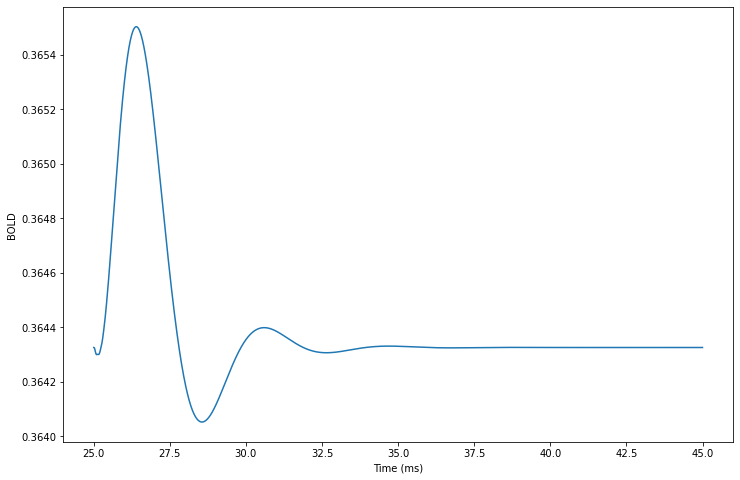

In [12]:
plt.figure(figsize=(12,8))

plt.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0])
plt.ylabel("BOLD")

plt.xlabel('Time (ms)')

About the balloon_dfun model as is

In [13]:
def balloon_dfun(self, state_variables, neural_input, local_coupling=0.0):
    s = state_variables[0, :]
    f = state_variables[1, :]
    v = state_variables[2, :]
    q = state_variables[3, :]

    x = neural_input[0, :]

    ds = x - (1. / self.tau_s) * s - (1. / self.tau_f) * (f - 1)
    df = s
    dv = (1. / self.tau_o) * (f - v ** (1. / self.alpha))
    dq = (1. / self.tau_o) * ((f * (1. - (1. - self.E0) ** (1. / f)) / self.E0) -
                              (v ** (1. / self.alpha)) * (q / v))

    return numpy.array([ds, df, dv, dq])

Some text (model hx/evolution)

### Friston 2000:
$$`G(t - t^{\prime}) =
             e^{\frac{1}{2} \left(\frac{t - t^{\prime}}{\tau_s} \right)}
             \frac{\sin\left((t - t^{\prime})
             \sqrt{\frac{1}{\tau_f} - \frac{1}{4 \tau_s^2}}\right)}
             {\sqrt{\frac{1}{\tau_f} - \frac{1}{4 \tau_s^2}}}
             \; \; \; \; \; \;  for \; \; \; t \geq t^{\prime}
             = 0 \; \; \; \; \; \;  for \; \; \;  t < t^{\prime}
$$

### Stephan 2007:

$$
\frac{ds}{dt} = x - \kappa\,s - \gamma \,(f-1) \\
\frac{df}{dt} = s \\
\frac{dv}{dt} = \frac{1}{\tau_o} \, (f - v^{1/\alpha})\\
\frac{dq}{dt} = \frac{1}{\tau_o}(f \, \frac{1-(1-E_0)^{1/\alpha}}{E_0} - v^{1/\alpha} \frac{q}{v})\\
\kappa = \frac{1}{\tau_s}\\
\gamma = \frac{1}{\tau_f}
$$

In [16]:
def reset_params():
    bold.BalloonModel.tau_s = H[0]
    bold.BalloonModel.tau_f = H[1]
    bold.BalloonModel.tau_o = H[2]
    bold.BalloonModel.alpha = H[3]
    bold.BalloonModel.E0 = H[4]

In [14]:
#H = np.array([1.54, 1.44, 0.98, 0.32, 0.40])
H = np.array([1.54, 2.46, 0.98, 0.33, 0.34]) 

In [17]:
reset_params()

In [18]:
bold_model = bold.BalloonModel(time_series = tsr)
bold_data_mod  = bold_model.evaluate()

/Users/pfc/Documents/GitHub/tvb-root/tvb_library/tvb/analyzers/fmri_balloon.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([k1, k2, k3])


Text(0.5, 0, 'Time (ms)')

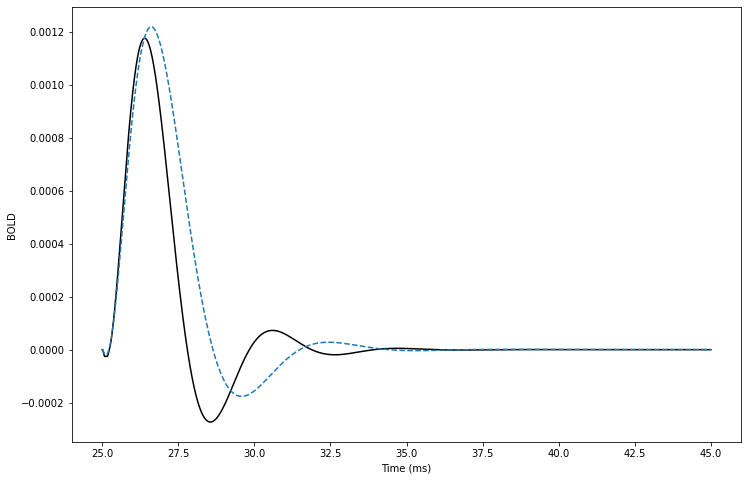

In [20]:
plt.figure(figsize=(12,8))

plt.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0] - bold_data.data[35000:45000, 0, [42], 0].mean(), c='k')
plt.plot(bold_data.time[25000:45000], bold_data_mod.data[25000:45000, 0, [42], 0] - bold_data_mod.data[35000:45000, 0, [42], 0].mean(), '--')
plt.ylabel("BOLD")

plt.xlabel('Time (ms)')

parameter modification after Friston 2000 Fig. 8

In [23]:
reset_params()
bold.BalloonModel.tau_s = 1.54 * 0.5 #1.54 / 1.54 (ref?)
bold_model = bold.BalloonModel(time_series = tsr)
bold_data_tau_s  = bold_model.evaluate()

/Users/pfc/Documents/GitHub/tvb-root/tvb_library/tvb/analyzers/fmri_balloon.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([k1, k2, k3])


In [24]:
reset_params()
bold.BalloonModel.tau_f = 1.44 * 2 #1.44 / 2.46
bold_model = bold.BalloonModel(time_series = tsr)
bold_data_tau_f  = bold_model.evaluate()

In [25]:
reset_params()
bold.BalloonModel.tau_o = 0.98 * 2 #0.98 / 0.98
bold_model = bold.BalloonModel(time_series = tsr)
bold_data_tau_o  = bold_model.evaluate()

In [26]:
reset_params()
bold.BalloonModel.alpha = 0.32 * 0.5 #0.32 / 0.33
bold_model = bold.BalloonModel(time_series = tsr)
bold_data_alpha  = bold_model.evaluate()

In [27]:
reset_params()
bold.BalloonModel.E0    = 0.34  * 2.3 #0.4 / 0.34
bold_model = bold.BalloonModel(time_series = tsr)
bold_data_E0  = bold_model.evaluate()

In [22]:
titles=['default parameter values',
        f'signal decay (x{H[0]})',
        f'autoregulation (x{H[1]})',
        f'transit time (x{H[2]})',
        f'stiffness (x{H[3]})',
        f'oxygen extraction (x{H[4]})']

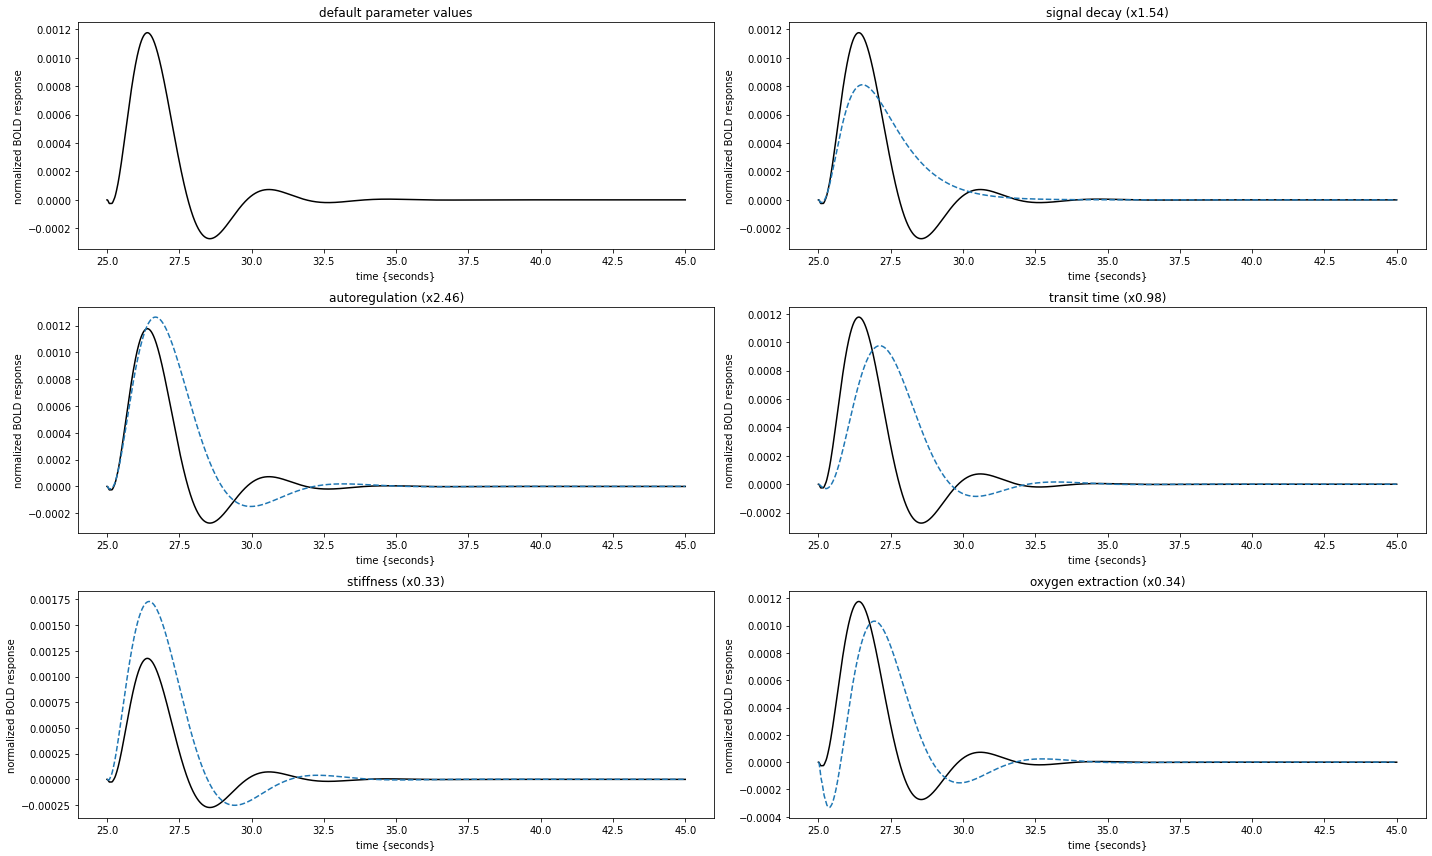

In [28]:
fig, ax = plt.subplots(ncols=2,nrows=3, figsize=(20,12))

a=ax[0,0];a.set_title(titles[0])
a.set_xlabel('time {seconds}');a.set_ylabel('normalized BOLD response')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0] - bold_data.data[35000:45000, 0, [42], 0].mean(), c='k')

a=ax[0,1];a.set_title(titles[1])
a.set_xlabel('time {seconds}');a.set_ylabel('normalized BOLD response')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0] - bold_data.data[35000:45000, 0, [42], 0].mean(), c='k')
a.plot(bold_data.time[25000:45000], bold_data_tau_s.data[25000:45000, 0, [42], 0] - bold_data_tau_s.data[35000:45000, 0, [42], 0].mean(), '--') 

a=ax[1,0];a.set_title(titles[2])
a.set_xlabel('time {seconds}');a.set_ylabel('normalized BOLD response')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0] - bold_data.data[35000:45000, 0, [42], 0].mean(), c='k')
a.plot(bold_data.time[25000:45000], bold_data_tau_f.data[25000:45000, 0, [42], 0] - bold_data_tau_f.data[35000:45000, 0, [42], 0].mean(), '--')

a=ax[1,1];a.set_title(titles[3])
a.set_xlabel('time {seconds}');a.set_ylabel('normalized BOLD response')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0] - bold_data.data[35000:45000, 0, [42], 0].mean(), c='k')
a.plot(bold_data.time[25000:45000], bold_data_tau_o.data[25000:45000, 0, [42], 0] - bold_data_tau_o.data[35000:45000, 0, [42], 0].mean(), '--')

a=ax[2,0];a.set_title(titles[4])
a.set_xlabel('time {seconds}');a.set_ylabel('normalized BOLD response')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0] - bold_data.data[35000:45000, 0, [42], 0].mean(), c='k')
a.plot(bold_data.time[25000:45000], bold_data_alpha.data[25000:45000, 0, [42], 0] - bold_data_alpha.data[35000:45000, 0, [42], 0].mean(), '--')

a=ax[2,1];a.set_title(titles[5])
a.set_xlabel('time {seconds}');a.set_ylabel('normalized BOLD response')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0] - bold_data.data[35000:45000, 0, [42], 0].mean(), c='k')
a.plot(bold_data.time[25000:45000], bold_data_E0.data[25000:45000, 0, [42], 0] - bold_data_E0.data[35000:45000, 0, [42], 0].mean(), '--')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Time (ms)')

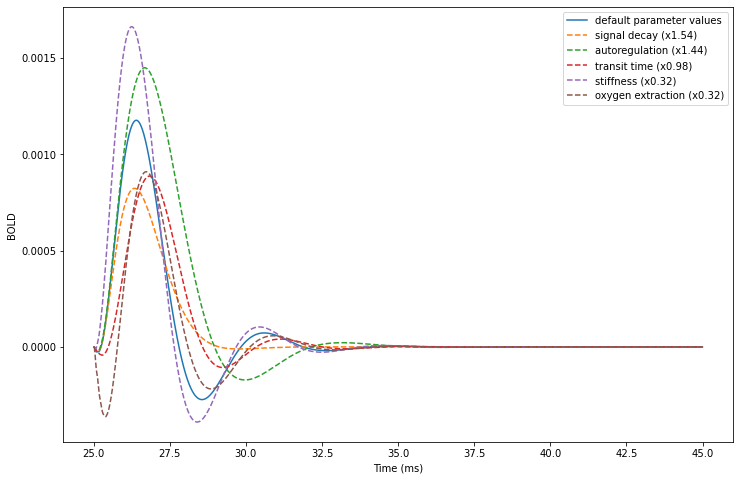

In [93]:
plt.figure(figsize=(12,8))
plt.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0] - bold_data.data[35000:45000, 0, [42], 0].mean())
plt.plot(bold_data.time[25000:45000], bold_data_tau_s.data[25000:45000, 0, [42], 0] - bold_data_tau_s.data[35000:45000, 0, [42], 0].mean(), '--')
plt.plot(bold_data.time[25000:45000], bold_data_tau_f.data[25000:45000, 0, [42], 0] - bold_data_tau_f.data[35000:45000, 0, [42], 0].mean(), '--')
plt.plot(bold_data.time[25000:45000], bold_data_tau_o.data[25000:45000, 0, [42], 0] - bold_data_tau_o.data[35000:45000, 0, [42], 0].mean(), '--')
plt.plot(bold_data.time[25000:45000], bold_data_alpha.data[25000:45000, 0, [42], 0] - bold_data_alpha.data[35000:45000, 0, [42], 0].mean(), '--')
plt.plot(bold_data.time[25000:45000], bold_data_E0.data[25000:45000, 0, [42], 0] - bold_data_E0.data[35000:45000, 0, [42], 0].mean(), '--')
plt.legend(titles)
plt.ylabel("BOLD")

plt.xlabel('Time (ms)')

In [ ]:
#TODO: set parameter values according to 2007 (classic/Buxton) and plot individually (H2[:])
#H2 = np.array([]) # Friston 2000, 2003, KES 2007, (Tak 2015), 2019?